# Fake news detector 
Link to dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Data preprocessing

In [3]:
fake_df = pd.read_csv('archive/Fake.csv')
true_df = pd.read_csv('archive/True.csv')

In [4]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [35]:
# Check for imbalance data

print("number of fake news:",len(fake_df))
print("number of real news:",len(true_df))

number of fake news: 23481
number of real news: 21417


In [5]:
fake_df['authenticity'] = 1
true_df['authenticity'] = 0

In [6]:
news_df = pd.concat([fake_df, true_df])

news_df.sample(10)

,title,text,subject,date,authenticity
18167,WATCH: CONSERVATIVE SOCIAL MEDIA GIANT Announc...,"Hilarious and spot-on conservative, social-med...",left-news,"Aug 10, 2017",1
21403,U.S. puts more pressure on Pakistan to help wi...,WASHINGTON (Reuters) - The United States sugge...,worldnews,"August 21, 2017",0
3880,White House postpones meeting to decide on par...,WASHINGTON (Reuters) - A meeting of Trump admi...,politicsNews,"May 9, 2017",0
10656,Committee chair McCain vows to block contract ...,WASHINGTON (Reuters) - U.S. Senate Armed Servi...,politicsNews,"February 25, 2016",0
17593,Hong Kong leader can't rule out barring even f...,HONG KONG (Reuters) - Hong Kong s leader denie...,worldnews,"October 13, 2017",0
16091,BRILLIANT! LT COL TONY SHAFFER: How Trump Shou...,Former CIA analyst and retired U.S. Army Reser...,Government News,"May 17, 2017",1
17388,"Kyrgyzstan vote count problems ""significant"": ...",BISHKEK (Reuters) - European observers said on...,worldnews,"October 16, 2017",0
21044,Homeless Man Dies Next To 4-STAR HOTEL…Your Bl...,LIBERAL COMPASSION: This story is a perfect ex...,left-news,"Feb 2, 2016",1
10899,Democratic nomination will likely be won in Ma...,NEW YORK (Reuters) - Hillary Clinton’s campaig...,politicsNews,"February 10, 2016",0
8202,Clinton cancels California trip after pneumoni...,NEW YORK (Reuters) - Democratic presidential c...,politicsNews,"September 12, 2016",0


In [7]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         44898 non-null  object
 1   text          44898 non-null  object
 2   subject       44898 non-null  object
 3   date          44898 non-null  object
 4   authenticity  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


<AxesSubplot:xlabel='authenticity', ylabel='count'>

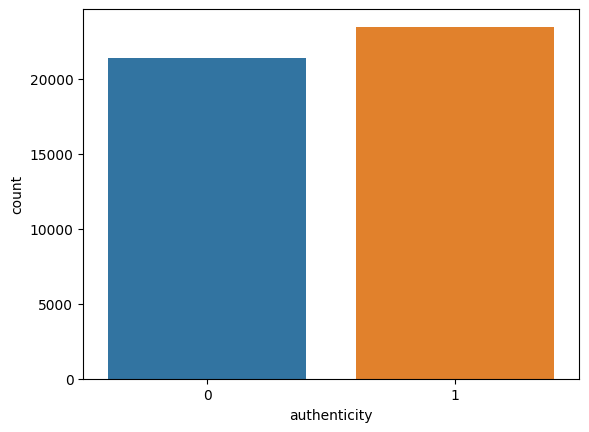

In [8]:
sns.countplot(x='authenticity', data=news_df)

In [9]:
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce') # If 'coerce', then invalid parsing will be set as NaT.
news_df['Year'] = news_df['date'].dt.year
news_df['Month'] = news_df['date'].dt.month

news_df.head()

,title,text,subject,date,authenticity,Year,Month
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,2017.0,12.0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,2017.0,12.0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,2017.0,12.0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,2017.0,12.0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,2017.0,12.0


In [10]:
# combining the title and text column and drop title column
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop(labels=['title'], axis=1, inplace=True)

In [11]:
# remove redundant columns
news_df.drop(labels=['subject','date', 'Year','Month'], axis=1, inplace=True)
news_df.head()

,text,authenticity
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1


In [12]:
news_df = news_df.sample(frac=1) # randomize 
news_df.sample(5)

,text,authenticity
5276,Analysis Shows Hillary Clinton’s Plans Would ...,1
9899,WOW! AMERICANS ARE STUNNED When Mom Is Caught ...,1
10001,"‘My Pillow’ CEO Mike Lindell Sending 60,000 Pi...",1
810,Senate Gives Trump Jr. Ultimatum: Respond By ...,1
12785,"Britain, EU agree on divorce bill, Northern Ir...",0


In [17]:
# Split the dataset into training and testing
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(
    news_df['text'].to_numpy(),
    news_df['authenticity'].to_numpy(),
    test_size=0.2,
    random_state=40)

In [18]:
len(train_x) == len(train_y)

True

### Vectorization
Vectorization is the process of converting string data into a numerical representation

In [19]:
max_vocab_length = 10000 # maximum size of the vocabulary that we will keep (top 10000 most frequent words)
max_length = 418
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [20]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_x)

In [44]:
sample_sentence_vectorizer = "Just checking the text vectorizer"
text_vectorizer([sample_sentence_vectorizer])

<tf.Tensor: shape=(1, 418), dtype=int64, numpy=
array([[  77, 8004,    2, 2814,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [23]:
import random

random_sentence = random.choice(train_x)

print(f"Original text;\n{random_sentence}\\n\n\nVectorized Version:\n\n{text_vectorizer([random_sentence])}")

Original text;
BREAKING: ANTI-TRUMP MUSLIM Known For Creating Drama To Post On You Tube Is Kicked Off Delta Flight…Screams Discrimination [VIDEO]YouTube celebrity Adam Saleh has accused Delta Air Lines of kicking him off flight because he spoke Arabic to his mom on the phone before takeoff.In a statement, Delta said:  Two customers were removed from this flight and later rebooked after a disturbance in the cabin resulted in more than 20 customers expressing their discomfort. We re conducting a full review to understand what transpired. We are taking allegations of discrimination very seriously; our culture requires treating others with respect. Saleh has more than 1.6 million subscribers to his TrueStoryASA YouTube channel, and more than 2.2 million subscribers to his Adam Saleh Vlogs YouTube channel. Saleh s YouTube channels are full of prank videos as well as videos about Muslim life, and he is a self-described  professional idiot. He said when he was speaking to his mom, a woman in 

### Embedding
Embedding layer enables us to convert each word into a fixed length vector of defined size. It is an alternative to one-hot encoding, which involved the use of dimensionality reduction. The resultant vector is a dense one with having real values instead of just 0’s and 1’s. The fixed length of word vectors helps us to represent words in a better way along with reduced dimensions.

one hot encoding - each word is coded with an index, which is represented by one-hot. If we use one-hot encoding on words in textual data, we will have a dummy feature for each word, which means 10,000 features for a vocabulary of 10,000 words. Not a feasible approach if scale of corpus becomes large.

In [24]:
from tensorflow.keras import layers
vector_length = 128
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=vector_length,
                             embeddings_initializer='uniform',
                             input_length=max_length)

In [25]:
random_sentence_2 = random.choice(train_x)
print(f"Original text:\n{random_sentence_2}\n\nEmbedd version: \n\ng {embedding(text_vectorizer([random_sentence_2]))}")

Original text:
 Obama SHAMES The Hell Out Of Trump And His Heartless Fans By Meeting This Young BoyPresident Obama has shown he s a human being with compassion time and again. Most recently, he met a 12-year old boy with severe cerebral palsy who had just been at a Trump rally the day before. What happened to him at the rally is exactly why Trump fans are deplorable, but Obama showed them how to act like humans, even if they aren t capable of it.J.J. Holmes braved one of Trump s rallies in order to protest the way that Trump makes fun of people with disabilities. Since he was a protester, he was very unwelcome already, but when Trump identified him and started saying,  Get them out,  security began trying to usher them away while Trump s deplorables pushed and kicked his wheelchair, according to J.J. s mother, Alison.Alison spoke to a pool reporter from the White House, saying,  We were put out by security,  and  The crowd started chanting  U-S-A  and pushing his wheelchair.  As she sa

### Using the LSTM Model

add the text vectorizer and embedding layer into the LSTM model

In [26]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')

# Pass inputs to text_vectorizer(convert text into numbers)
x = text_vectorizer(inputs) 

# Convert text_vectorizer layer into embedding layer
x = embedding(x)

# Model 
x = layers.LSTM(64)(x)

# output
outputs = layers.Dense(1, activation='sigmoid')(x)

# Pass inputs and outputs to our model
model = tf.keras.Model(inputs, outputs, name='model_LSTM')

In [27]:
model.summary()

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 418)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 418, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
______________________________________________

In [28]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [29]:
EPOCH = 20
# Fit the model
model_history = model.fit(train_x,
                          train_y,
                          epochs=EPOCH,
                          validation_data=(val_x, val_y))

Epoch 1/20
1123/1123 [==============================] - 302s 264ms/step - loss: 0.3954 - accuracy: 0.8365 - val_loss: 0.2344 - val_accuracy: 0.9323
Epoch 2/20
1123/1123 [==============================] - 290s 258ms/step - loss: 0.2711 - accuracy: 0.9014 - val_loss: 0.1618 - val_accuracy: 0.9523
Epoch 3/20
1123/1123 [==============================] - 309s 275ms/step - loss: 0.1826 - accuracy: 0.9441 - val_loss: 0.1368 - val_accuracy: 0.9604
Epoch 4/20
1123/1123 [==============================] - 446s 397ms/step - loss: 0.2342 - accuracy: 0.9289 - val_loss: 0.2244 - val_accuracy: 0.9592
Epoch 5/20
1123/1123 [==============================] - 449s 399ms/step - loss: 0.1500 - accuracy: 0.9581 - val_loss: 0.1111 - val_accuracy: 0.9677
Epoch 6/20
1123/1123 [==============================] - 347s 309ms/step - loss: 0.1496 - accuracy: 0.9508 - val_loss: 0.0724 - val_accuracy: 0.9754
Epoch 7/20
1123/1123 [==============================] - 301s 268ms/step - loss: 0.0417 - accuracy: 0.9898 - val_

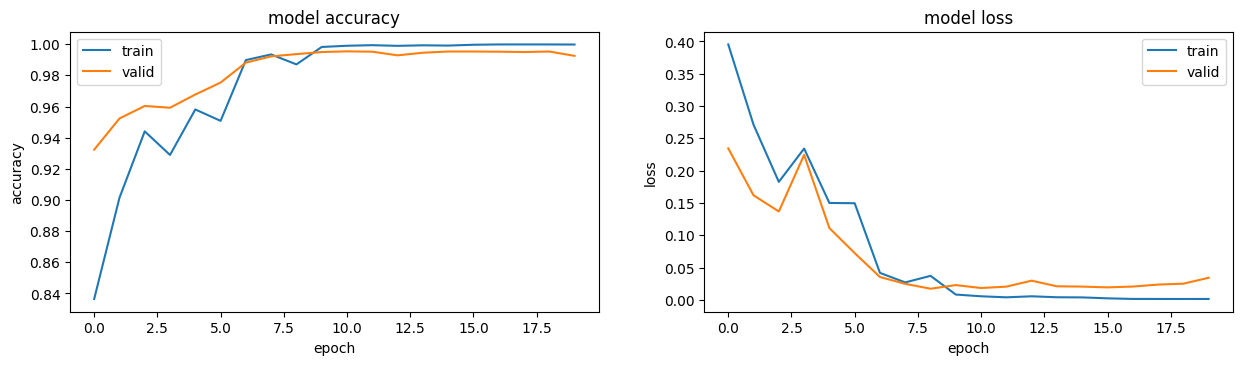

In [30]:
# Plotting training & validation error and loss function over epochs
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(model_history.history['accuracy'])  
plt.plot(model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(model_history.history['loss'])  
plt.plot(model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

In [33]:
model_prediction = model.predict(val_x)
model_prediction[:10]

281/281 [==============================] - 26s 90ms/step


array([[2.54886108e-04],
       [5.57662606e-05],
       [1.06782529e-04],
       [5.24204115e-05],
       [9.99865830e-01],
       [2.85056361e-04],
       [9.99932349e-01],
       [9.92611408e-01],
       [1.17919095e-04],
       [3.53754091e-04]], dtype=float32)

In [32]:
# Convert model prediction to our val_labels (0,1)
model_preds = tf.squeeze(tf.round(model_prediction))
model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 1., 1., 0., 0.], dtype=float32)>

In [34]:
# Evaluatinon metrics
from sklearn.metrics import accuracy_score, recall_score,precision_score, f1_score

print(f"Accuracy Score: {accuracy_score(val_y,model_preds)}")
print(f"Recall Score : {recall_score(val_y, model_preds)}")
print(f"Precsion Score : {precision_score(val_y, model_preds)}")
print(f"f1 Score : {f1_score(val_y, model_preds)}")

Accuracy Score: 0.9925389755011136
Recall Score : 0.9888388066108607
Precsion Score : 0.9967546516659455
f1 Score : 0.9927809503286283
